In [5]:
import gymnasium as gym
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
import numpy as np

# 读取数据文件
with open('expert_data.txt', 'r') as file:
    header = file.readline()
    data_lines = file.readlines()

# 解析形状信息
data_shape = tuple(map(int, header.strip().replace('(','').replace(')','').split(',')))
data_shape[1]
loaded_data = np.zeros(data_shape)
for i, line in enumerate(data_lines):
    loaded_data[i] = np.fromstring(line, sep=',')

# 将加载的数据分隔为 expert_s 和 expert_a 数组
expert_s = loaded_data[:, :-1]
expert_a = loaded_data[:, -1:]

In [7]:
class PolicyNet(torch.nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(PolicyNet,self).__init__()
        self.fc1=torch.nn.Linear(state_dim,hidden_dim)
        self.fc2=torch.nn.Linear(hidden_dim,action_dim)
        self.softmax=torch.nn.Softmax()
    def forward(self,x):
        x=torch.relu(self.fc1(x))
        x=self.fc2(x)
        return self.softmax(x)

In [8]:
class BehaviorClone():
    def __init__(self,state_dim,hidden_dim,action_dim,lr,device):
        self.policy=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.device=device
        self.policy.optimizer=torch.optim.Adam(self.policy.parameters(),lr)
    def take_action(self,state):
        state=torch.tensor([state],dtype=torch.float).to(self.device)
        probs=self.policy(state)
        action_dist=torch.distributions.Categorical(probs)
        action=action_dist.sample()
        return action.item()
    def learn(self,states,actions):
        states=torch.tensor(states,dtype=torch.float).to(self.device)
        actions=torch.tensor(actions,dtype=torch.int64).view(-1,1).to(self.device)
        log_probs=torch.log(self.policy(states).gather(1,actions))
        loss=torch.mean(-log_probs)
        self.policy.optimizer.zero_grad()
        loss.backward()
        self.policy.optimizer.step()
def test_agent(agent,state,n_episodes):
    return_list=[]
    for episode in range(n_episodes):
        state=env.reset(seed=0)[0]
        done=False
        episode_return=0
        while not done:
            action=agent.take_action(state)
            next_state,reward,terminated,truncated,_=env.step(action)
            done=terminated or truncated
            state=next_state
            episode_return+=reward
        return_list.append(episode_return)
    return return_list       

In [9]:
env_name="CartPole-v1"
env=gym.make(env_name)
torch.manual_seed(0)
lr=1e-3
device=torch.device("cuda") if torch.cuda.is_available() else torch.absdevice("cpu")
state_dim=env.observation_space.shape[0]
action_dim=env.action_space.n
hidden_dim=128
agent=BehaviorClone(state_dim,hidden_dim,action_dim,lr,device)
n_episodes=10
n_iterations=1000
batchsize=64
test_returns=[]

with tqdm(total=n_iterations,desc="进度条") as pbar:
    for iteration in range(n_iterations):
        sample_dicts=np.random.randint(low=0,high=expert_s.shape[0],size=batchsize)
        agent.learn(expert_s[sample_dicts],expert_a[sample_dicts])
        current_return = test_agent(agent, env, 10)
        test_returns.append(current_return)
        if (iteration + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)


进度条:   0%|                                                                     | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_894101/998010583.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)
/tmp/ipykernel_894101/4136155817.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/torch/csrc/utils/tensor_new.cpp:201.)
  state=torch.tensor([state],dtype=torch.float).to(self.device)
进度条: 100%|██████████████████████████████████████████| 1000/1000 [17:48<00:00,  1.07s/it, return=226.580]


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

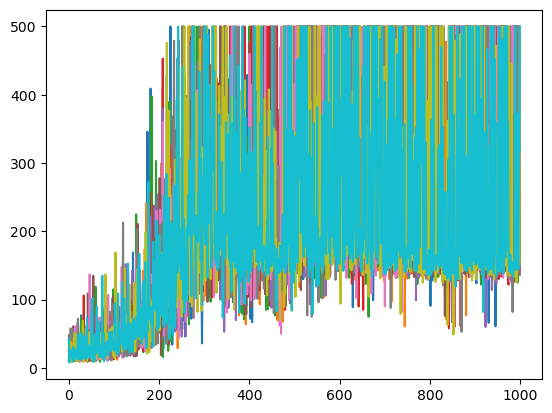

In [10]:
iteration_list=range(len(test_returns))
plt.plot(iteration_list,test_returns)
plt.xlable("iteration")
plt.ylable("return")
plt.title("BC on {}".format(env_name))
plt.show()